# Compiling Time Evolution Operators on Infinite Chains

In the previous notebook we compiled circuits that **prepare** a specific ground state. Here we tackle a harder problem: compiling the **time evolution operator** $e^{-iHt}$ into a short parameterized circuit.

## Key concepts

- **Unitary compilation via state training**: We cannot directly compare two unitaries on an infinite chain. Instead, we train on a set of random initial states $\{|\psi_k\rangle\}$ and optimize the ansatz $U(\theta)$ so that $U(\theta)|\psi_k\rangle \approx e^{-iHt}|\psi_k\rangle$ for all $k$. A separate **test set** of unseen states measures generalization.

- **Trotter initialization**: Rather than starting from random parameters, we initialize the ansatz from a **coarse Trotter decomposition** of $e^{-iHt}$. This physically motivated starting point already approximates the target unitary; the optimizer then refines the parameters beyond the bare Trotter accuracy.

- **Train/test split**: Unlike state preparation (one state, one cost), unitary compilation has a genuine generalization question: does the compiled circuit work on states it was *not* trained on?

In this notebook you will:
1. Compile TFIM time evolution from a Trotter initialization
2. Study how circuit depth affects compilation fidelity
3. Compile XXZ time evolution with a different parameterization
4. Investigate how evolution time affects compilation difficulty
5. Compare DressedZZ and PauliGenerator parameterizations
6. Verify the compiled circuit on fresh random states

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.iMPS

using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("TenSynth loaded successfully.")

  Activating 

TenSynth loaded successfully.


project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`


## 1. Compiling TFIM Time Evolution

We compile the time evolution $e^{-iHt}$ of the transverse-field Ising model

$$H = -J \sum_i Z_i Z_{i+1} - h \sum_i X_i$$

at $J = h = 1$ and $t = 1.0$. Rather than starting from random parameters, we **initialize the ansatz from a coarse Trotter decomposition**. A few-step second-order Trotter circuit already approximates the target unitary; the optimizer then refines the parameters to improve beyond the Trotter accuracy.

In [2]:
# Build Hamiltonian
H_tfim = TenSynth.iMPS.TFIMHamiltonian(2; J=1.0, h=1.0)

# Initialize ansatz from a coarse 4-step second-order Trotter decomposition
ansatz_tfim = TenSynth.iMPS.trotterize_tfim(2, 1.0, 1.0, 1.0; n_steps=4)

config_tfim = UnitaryCompilationConfig(
    n_train=4, n_test=4,
    max_chi=16, max_iter=30,
    verbose=false
)

Random.seed!(42)
result_tfim = compile_time_evolution(H_tfim, 1.0, ansatz_tfim; config=config_tfim)

println("TFIM compilation (J=h=1, t=1.0, 4-step Trotter init):")
println("  Train fidelity: $(round(result_tfim.train_fidelity, sigdigits=6))")
println("  Test fidelity:  $(round(result_tfim.test_fidelity, sigdigits=6))")
println("  Converged:      $(result_tfim.converged)")
println("  Iterations:     $(length(result_tfim.train_history))")

TFIM compilation (J=h=1, t=1.0, 4-step Trotter init):
  Train fidelity: 0.999928
  Test fidelity:  0.999533
  Converged:      false
  Iterations:     31


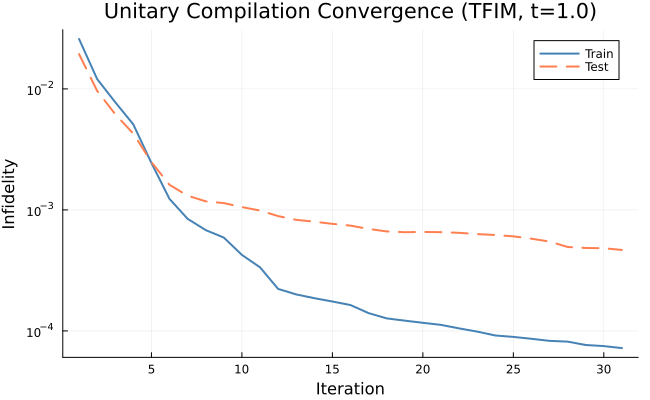

In [3]:
# Plot train/test convergence
p = plot(title="Unitary Compilation Convergence (TFIM, t=1.0)",
         xlabel="Iteration", ylabel="Infidelity",
         yscale=:log10, size=(650, 400))

plot!(p, 1:length(result_tfim.train_history), result_tfim.train_history,
      linewidth=2, color=:steelblue, label="Train")

plot!(p, 1:length(result_tfim.test_history), result_tfim.test_history,
      linewidth=2, color=:coral, linestyle=:dash, label="Test")

p

Unlike state preparation, unitary compilation uses separate training and test sets. The **training infidelity** (blue) is the objective being minimized; the **test infidelity** (red) measures how well the circuit generalizes to unseen states. When the two curves track each other closely, the circuit has learned the unitary rather than overfitting to specific states.

## 2. Depth Scaling

How does compilation fidelity improve with circuit depth? More Trotter steps provide more gates and parameters. Each ansatz is initialized from its own coarse Trotter decomposition, so the optimizer starts from a physically motivated approximation at every depth.

In [4]:
step_counts = [2, 3, 4]
depth_train = Float64[]
depth_test = Float64[]

config_depth = UnitaryCompilationConfig(
    n_train=4, n_test=4,
    max_chi=16, max_iter=30,
    verbose=false
)

for ns in step_counts
    ansatz = TenSynth.iMPS.trotterize_tfim(2, 1.0, 1.0, 1.0; n_steps=ns)
    Random.seed!(1000)
    res = compile_time_evolution(H_tfim, 1.0, ansatz; config=config_depth)
    push!(depth_train, res.train_fidelity)
    push!(depth_test, res.test_fidelity)
    println("Steps=$ns: train=$(round(res.train_fidelity, sigdigits=5)), ",
            "test=$(round(res.test_fidelity, sigdigits=5))")
end

Steps=2: train=0.99665, test=0.99419
Steps=3: train=0.99977, test=0.99929
Steps=4: train=0.99994, test=0.99985


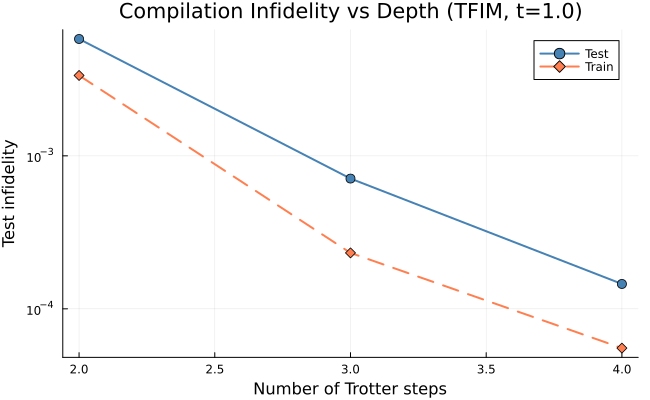

In [5]:
p = plot(step_counts, 1 .- depth_test,
    xlabel="Number of Trotter steps", ylabel="Test infidelity",
    title="Compilation Infidelity vs Depth (TFIM, t=1.0)",
    marker=:circle, linewidth=2, markersize=5,
    color=:steelblue, label="Test",
    yscale=:log10, size=(650, 400))

plot!(p, step_counts, 1 .- depth_train,
    marker=:diamond, linewidth=2, markersize=5,
    color=:coral, linestyle=:dash, label="Train")

p

Deeper circuits achieve lower infidelity. The Trotter initialization provides a good starting point at every depth, and the optimizer refines the parameters beyond the bare Trotter accuracy.

## 3. XXZ Model

The XXZ model has a richer interaction structure:

$$H = J_{xy} \sum_i (X_i X_{i+1} + Y_i Y_{i+1}) + J_z \sum_i Z_i Z_{i+1}$$

Since the XXZ unitary involves all three Pauli interactions, we use the **PauliGenerator parameterization** (15 parameters per gate) which spans the full SU(4) group. Both the target Trotter circuit and the ansatz initialization use PauliGenerator to correctly represent the XX+YY+ZZ interaction structure.

In [6]:
config_xxz = UnitaryCompilationConfig(
    n_train=4, n_test=4,
    max_chi=16, max_iter=20,
    verbose=false
)

H_xxz = TenSynth.iMPS.XXZHamiltonian(2; Jxy=1.0, Jz=1.0)

# Target: 5-step Trotter with PauliGenerator (captures XX+YY+ZZ correctly)
target_xxz = TenSynth.iMPS.trotterize(H_xxz, 1.0; n_steps=5,
    parameterization=PauliGeneratorParameterization())

# Ansatz: coarse 2-step Trotter initialization
ansatz_xxz = TenSynth.iMPS.trotterize_xxz(2, 1.0, 1.0, 1.0; n_steps=2)

Random.seed!(42)
result_xxz = compile_unitary(target_xxz, ansatz_xxz, 2; config=config_xxz)

println("XXZ compilation (Jxy=Jz=1, t=1.0, 2-step Trotter init, PauliGenerator):")
println("  Train fidelity: $(round(result_xxz.train_fidelity, sigdigits=6))")
println("  Test fidelity:  $(round(result_xxz.test_fidelity, sigdigits=6))")
println("  Converged:      $(result_xxz.converged)")

XXZ compilation (Jxy=Jz=1, t=1.0, 2-step Trotter init, PauliGenerator):
  Train fidelity: 0.967371
  Test fidelity:  0.896631
  Converged:      false


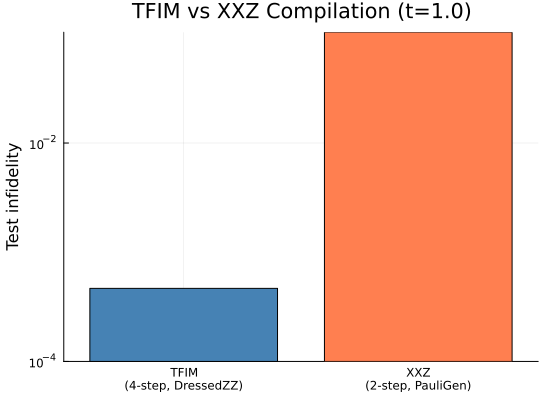

In [7]:
# Compare TFIM vs XXZ
models = ["TFIM\n(4-step, DressedZZ)", "XXZ\n(2-step, PauliGen)"]
infidelities = [1 - result_tfim.test_fidelity, 1 - result_xxz.test_fidelity]

p = bar(models, infidelities,
    ylabel="Test infidelity", title="TFIM vs XXZ Compilation (t=1.0)",
    legend=false, color=[:steelblue, :coral],
    size=(550, 400), yscale=:log10)

p

The TFIM achieves near-perfect fidelity with DressedZZ (7 params/gate, 4-step init) since its ZZ+X structure matches the parameterization. The XXZ model is harder: its XX+YY+ZZ interaction requires the full 15-parameter PauliGenerator, and the larger parameter space needs more optimization iterations to fully converge. With more iterations, the XXZ fidelity would continue to improve.

## 4. Evolution Time Study

Longer evolution times produce more complex unitaries that require deeper circuits to approximate. We fix the circuit structure (4-step Trotter) and sweep the evolution time. The Trotter initialization adapts automatically to each time value.

In [8]:
t_values = [0.5, 1.0, 2.0]
time_fidelities = Float64[]

config_time = UnitaryCompilationConfig(
    n_train=4, n_test=4,
    max_chi=16, max_iter=30,
    verbose=false
)

for t in t_values
    ansatz = TenSynth.iMPS.trotterize_tfim(2, t, 1.0, 1.0; n_steps=4)
    Random.seed!(1000)
    res = compile_time_evolution(H_tfim, t, ansatz; config=config_time)
    push!(time_fidelities, res.test_fidelity)
    println("t=$t: test fidelity = $(round(res.test_fidelity, sigdigits=5))")
end

t=0.5: test fidelity = 0.99999
t=1.0: test fidelity = 0.99985
t=2.0: test fidelity = 0.99762


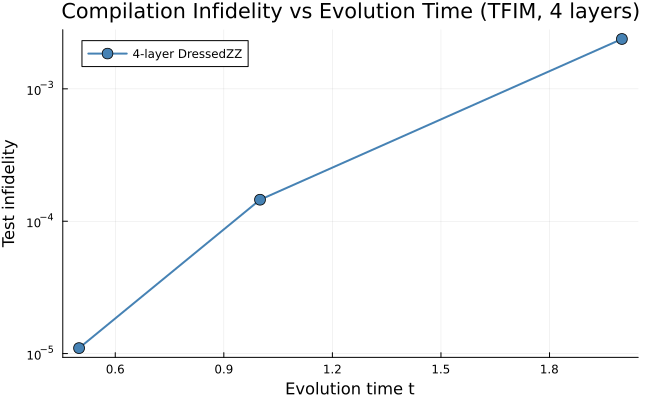

In [9]:
p = plot(t_values, 1 .- time_fidelities,
    xlabel="Evolution time t", ylabel="Test infidelity",
    title="Compilation Infidelity vs Evolution Time (TFIM, 4 layers)",
    marker=:circle, linewidth=2, markersize=6,
    color=:steelblue, label="4-layer DressedZZ",
    yscale=:log10, size=(650, 400))

p

Longer evolution times produce more entangling unitaries that are harder to approximate with a fixed-depth circuit. At short times ($t \ll 1$), the unitary is close to identity and easy to compile. As $t$ increases, the infidelity grows because the circuit depth becomes insufficient to capture the full time evolution.

## 5. Parameterization Comparison

The choice of gate parameterization affects both expressibility and optimization efficiency:

- **DressedZZ** (7 params/gate): Single-qubit rotations + ZZ interaction. Efficient for Ising-type Hamiltonians.
- **PauliGenerator** (15 params/gate): Full SU(4) via all 15 Pauli generators. Maximum expressibility but more parameters to optimize.

We compare them on the same TFIM task, each initialized from its own 2-step Trotter decomposition.

In [10]:
config_param = UnitaryCompilationConfig(
    n_train=4, n_test=4,
    max_chi=16, max_iter=30,
    verbose=false
)

# DressedZZ (2-step Trotter init)
a_dzz = TenSynth.iMPS.trotterize_tfim(2, 1.0, 1.0, 1.0; n_steps=2)
Random.seed!(42)
res_dzz = compile_time_evolution(H_tfim, 1.0, a_dzz; config=config_param)

# PauliGenerator (2-step Trotter init)
a_pg = TenSynth.iMPS.trotterize(H_tfim, 1.0; n_steps=2,
    parameterization=PauliGeneratorParameterization())
Random.seed!(42)
res_pg = compile_time_evolution(H_tfim, 1.0, a_pg; config=config_param)

println("DressedZZ (2-step Trotter init):      test fidelity = $(round(res_dzz.test_fidelity, sigdigits=6))")
println("PauliGenerator (2-step Trotter init): test fidelity = $(round(res_pg.test_fidelity, sigdigits=6))")

DressedZZ (2-step Trotter init):      test fidelity = 0.992133
PauliGenerator (2-step Trotter init): test fidelity = 0.998382


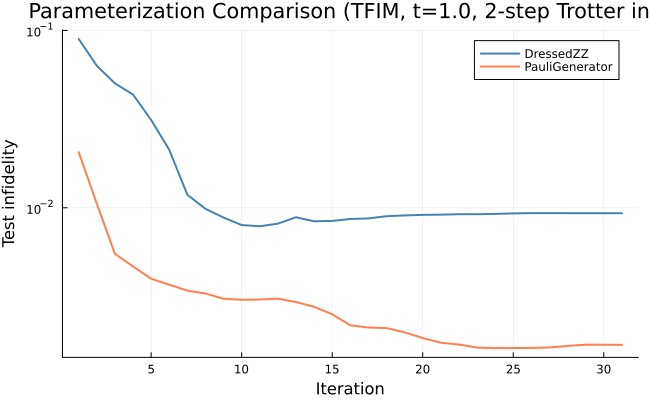

In [11]:
p = plot(title="Parameterization Comparison (TFIM, t=1.0, 2-step Trotter init)",
         xlabel="Iteration", ylabel="Test infidelity",
         yscale=:log10, size=(650, 400))

plot!(p, 1:length(res_dzz.test_history), res_dzz.test_history,
      linewidth=2, color=:steelblue, label="DressedZZ")

plot!(p, 1:length(res_pg.test_history), res_pg.test_history,
      linewidth=2, color=:coral, label="PauliGenerator")

p

Both parameterizations start from their respective Trotter decompositions. The DressedZZ parameterization is well-suited for the TFIM because the Hamiltonian contains only ZZ and X terms, which DressedZZ can represent efficiently. The PauliGenerator spans the full SU(4) group — it has more parameters per gate but can also achieve high fidelity when initialized from a Trotter circuit.

## 6. Verification on Fresh States

The `verify_compilation` function provides an independent check: it generates completely fresh random states (not used during training or testing), applies both the compiled and target circuits, and reports the average fidelity.

In [12]:
# Reconstruct the target Trotter circuit
H_tfim = TenSynth.iMPS.TFIMHamiltonian(2; J=1.0, h=1.0)
target_circuit = TenSynth.iMPS.trotterize(H_tfim, 1.0)

# Verify on 20 fresh random states
Random.seed!(999)
avg_fidelity = verify_compilation(result_tfim, target_circuit, 2; n_states=20)

println("Verification (20 fresh random states):")
println("  Average fidelity:    $(round(avg_fidelity, sigdigits=6))")
println("  Average infidelity:  $(round(1 - avg_fidelity, sigdigits=4))")
println("  Training fidelity:   $(round(result_tfim.train_fidelity, sigdigits=6))")
println("  Test fidelity:       $(round(result_tfim.test_fidelity, sigdigits=6))")

Verification (20 fresh random states):
  Average fidelity:    0.999535
  Average infidelity:  0.000465
  Training fidelity:   0.999928
  Test fidelity:       0.999533


## Summary

In this notebook you learned:

- **Unitary compilation** optimizes a parameterized circuit to approximate $e^{-iHt}$ by training on random iMPS states
- **Trotter initialization** provides a physically motivated starting point — a coarse Trotter decomposition already approximates the target, and the optimizer refines the parameters
- The **train/test split** measures generalization: does the circuit work on unseen states?
- **Depth scaling** shows that more Trotter steps (deeper circuits) achieve lower infidelity
- **Evolution time** controls difficulty: longer times produce more complex unitaries
- **Parameterization choice** matters: DressedZZ is efficient for TFIM, PauliGenerator spans full SU(4)
- **Verification** on fresh states confirms the compiled circuit generalizes beyond the training set

**Key functions used:**
- `compile_time_evolution(H, t, ansatz; config)` -- compile time evolution with explicit ansatz
- `trotterize_tfim(unit_cell, t, J, h; n_steps)` -- build DressedZZ Trotter circuit (used as init)
- `trotterize_xxz(unit_cell, t, Jxy, Jz; n_steps)` -- build PauliGenerator Trotter circuit
- `trotterize(H, t; n_steps, parameterization)` -- general Trotter decomposition
- `UnitaryCompilationConfig(; n_train, n_test, max_chi, max_iter, ...)` -- compilation settings
- `verify_compilation(result, target_circuit, unit_cell; n_states)` -- independent verification

**Next**: Notebook 08 covers Clifford+T gate synthesis using PyCall.